In [1]:
import pandas as pd
# import dask.dataframe as dd
from datetime import datetime
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedKFold
from xgboost import XGBRegressor, plot_importance
import shap

In [2]:
data_path = '/Users/sg/projects/EDS-I-Group-Project/data'

In [3]:
import mlflow

remote_server_uri = "databricks" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("/my-experiment")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/173139626917049', experiment_id='173139626917049', lifecycle_stage='active', name='/my-experiment', tags={'mlflow.experiment.sourceName': '/my-experiment',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'shivanshug14+unsub@gmail.com',
 'mlflow.ownerId': '3176862807905950'}>

In [4]:
sales = pd.read_csv(f'{data_path}/family_stores_unit_sales.csv').sort_values(by=['year_week', 'family'])
print(sales.shape)
sales.head()

(12672, 5)


,family,store_nbr,year_week,unit_sales,type
0,BEVERAGES,10,201301,4349.0,C
4302,BEVERAGES,27,201301,10020.0,D
7120,BEVERAGES,43,201301,12950.0,E
9854,BEVERAGES,46,201301,24198.0,A
243,BREAD/BAKERY,10,201301,781.0,C


In [5]:
sales['type'].unique()

array(['C', 'D', 'E', 'A', 'B'], dtype=object)

In [6]:
family = 'GROCERY I'
store_type = 'E'
df = sales.loc[
    (sales['family'] == family) &
    (sales['type'] == store_type) 
].drop(columns=['family', 'type', 'store_nbr'])
df.head()

,year_week,unit_sales
8578,201301,18312.0
8579,201302,11419.0
8580,201303,11204.0
8581,201304,11211.0
8582,201305,13234.0


In [7]:
df['year'] = df['year_week'].apply(lambda x: int(str(x)[:4])) # 201401 --> 2014
df['week'] = df['year_week'].apply(lambda x: int(str(x)[-2:])) # 201401 --> 1
df.head()

,year_week,unit_sales,year,week
8578,201301,18312.0,2013,1
8579,201302,11419.0,2013,2
8580,201303,11204.0,2013,3
8581,201304,11211.0,2013,4
8582,201305,13234.0,2013,5


In [8]:
df['date'] = df['year_week'].apply(lambda x: datetime.strptime(str(x) + '-1', '%Y%W-%w'))
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df

,year_week,unit_sales,year,week
date,,,,
2013-01-07,201301,18312.000,2013,1
2013-01-14,201302,11419.000,2013,2
2013-01-21,201303,11204.000,2013,3
2013-01-28,201304,11211.000,2013,4
2013-02-04,201305,13234.000,2013,5
...,...,...,...,...
2017-07-17,201729,30704.038,2017,29
2017-07-24,201730,34821.180,2017,30
2017-07-31,201731,37407.993,2017,31


In [9]:
df = pd.DataFrame(df.groupby(df.index).sum()['unit_sales']).reset_index()
df.dtypes

date          datetime64[ns]
unit_sales           float64
dtype: object

In [10]:
week_dates_df = pd.read_csv(f'{data_path}/week_dates.csv')
week_dates_df['date'] = pd.to_datetime(week_dates_df['date']) + pd.Timedelta(days=1)
week_dates_df

,date
0,2013-01-07
1,2013-01-14
2,2013-01-21
3,2013-01-28
4,2013-02-04
...,...
256,2017-12-04
257,2017-12-11
258,2017-12-18
259,2017-12-25


Why are we merging with the `weeks` dataframe? 
(See https://github.com/shiv-io/EDS-I-Group-Project/issues/33)

In [11]:
df_ts = pd.merge(
    left=week_dates_df,
    right=df,
    left_on='date',
    right_on='date',
    how='left'
)
df_ts

,date,unit_sales
0,2013-01-07,18312.0
1,2013-01-14,11419.0
2,2013-01-21,11204.0
3,2013-01-28,11211.0
4,2013-02-04,13234.0
...,...,...
256,2017-12-04,NaN
257,2017-12-11,NaN
258,2017-12-18,NaN
259,2017-12-25,NaN


No sales data after 2017-08-21:

In [12]:
df_ts.loc[df_ts['unit_sales'].isna()]

,date,unit_sales
241,2017-08-21,NaN
242,2017-08-28,NaN
243,2017-09-04,NaN
244,2017-09-11,NaN
245,2017-09-18,NaN
246,2017-09-25,NaN
247,2017-10-02,NaN
248,2017-10-09,NaN
249,2017-10-16,NaN
250,2017-10-23,NaN


We'll get rid of the null rows above.

In [13]:
df_ts = df_ts.loc[df_ts['date']<'2017-08-21']
df_ts

,date,unit_sales
0,2013-01-07,18312.000
1,2013-01-14,11419.000
2,2013-01-21,11204.000
3,2013-01-28,11211.000
4,2013-02-04,13234.000
...,...,...
236,2017-07-17,30704.038
237,2017-07-24,34821.180
238,2017-07-31,37407.993
239,2017-08-07,34445.133


Let's make sure there are no more nulls.

In [14]:
# Let's make sure there are no more nulls
assert df_ts['unit_sales'].isna().sum() == 0, 'There are nulls in the data!'

In [15]:
df = df_ts

## Generate time-series features

In [16]:
df['unit_sales_lag_1'] = df['unit_sales'].shift(1)
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,unit_sales,unit_sales_lag_1
0,2013-01-07,18312.000,NaN
1,2013-01-14,11419.000,18312.000
2,2013-01-21,11204.000,11419.000
3,2013-01-28,11211.000,11204.000
4,2013-02-04,13234.000,11211.000
...,...,...,...
236,2017-07-17,30704.038,32572.196
237,2017-07-24,34821.180,30704.038
238,2017-07-31,37407.993,34821.180
239,2017-08-07,34445.133,37407.993


In [17]:
df['unit_sales_ma_2_lag_1'] = df['unit_sales'].rolling(2).mean().shift(1)
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,unit_sales,unit_sales_lag_1,unit_sales_ma_2_lag_1
0,2013-01-07,18312.000,NaN,NaN
1,2013-01-14,11419.000,18312.000,NaN
2,2013-01-21,11204.000,11419.000,14865.5000
3,2013-01-28,11211.000,11204.000,11311.5000
4,2013-02-04,13234.000,11211.000,11207.5000
...,...,...,...,...
236,2017-07-17,30704.038,32572.196,34593.5595
237,2017-07-24,34821.180,30704.038,31638.1170
238,2017-07-31,37407.993,34821.180,32762.6090
239,2017-08-07,34445.133,37407.993,36114.5865


In [18]:
def difference_in_percentage(data, feature):
    # assume data is already sorted
    lag_by_1 = data[feature].shift(1)
    return (data[feature] - lag_by_1)/(lag_by_1)

df['pct_change_lag_1_func'] = difference_in_percentage(df, 'unit_sales')
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,unit_sales,unit_sales_lag_1,unit_sales_ma_2_lag_1,pct_change_lag_1_func
0,2013-01-07,18312.000,NaN,NaN,NaN
1,2013-01-14,11419.000,18312.000,NaN,-0.376420
2,2013-01-21,11204.000,11419.000,14865.5000,-0.018828
3,2013-01-28,11211.000,11204.000,11311.5000,0.000625
4,2013-02-04,13234.000,11211.000,11207.5000,0.180448
...,...,...,...,...,...
236,2017-07-17,30704.038,32572.196,34593.5595,-0.057354
237,2017-07-24,34821.180,30704.038,31638.1170,0.134091
238,2017-07-31,37407.993,34821.180,32762.6090,0.074288
239,2017-08-07,34445.133,37407.993,36114.5865,-0.079204


In [19]:
df['week'] = df['date'].dt.week
df['week'] = df['week'].astype('int')
df['month'] =df['date'].dt.month
df['year'] = df['date'].dt.year
df

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,date,unit_sales,unit_sales_lag_1,unit_sales_ma_2_lag_1,pct_change_lag_1_func,week,month,year
0,2013-01-07,18312.000,NaN,NaN,NaN,2,1,2013
1,2013-01-14,11419.000,18312.000,NaN,-0.376420,3,1,2013
2,2013-01-21,11204.000,11419.000,14865.5000,-0.018828,4,1,2013
3,2013-01-28,11211.000,11204.000,11311.5000,0.000625,5,1,2013
4,2013-02-04,13234.000,11211.000,11207.5000,0.180448,6,2,2013
...,...,...,...,...,...,...,...,...
236,2017-07-17,30704.038,32572.196,34593.5595,-0.057354,29,7,2017
237,2017-07-24,34821.180,30704.038,31638.1170,0.134091,30,7,2017
238,2017-07-31,37407.993,34821.180,32762.6090,0.074288,31,7,2017
239,2017-08-07,34445.133,37407.993,36114.5865,-0.079204,32,8,2017


In [20]:
df.iloc[:,0:]

,date,unit_sales,unit_sales_lag_1,unit_sales_ma_2_lag_1,pct_change_lag_1_func,week,month,year
0,2013-01-07,18312.000,NaN,NaN,NaN,2,1,2013
1,2013-01-14,11419.000,18312.000,NaN,-0.376420,3,1,2013
2,2013-01-21,11204.000,11419.000,14865.5000,-0.018828,4,1,2013
3,2013-01-28,11211.000,11204.000,11311.5000,0.000625,5,1,2013
4,2013-02-04,13234.000,11211.000,11207.5000,0.180448,6,2,2013
...,...,...,...,...,...,...,...,...
236,2017-07-17,30704.038,32572.196,34593.5595,-0.057354,29,7,2017
237,2017-07-24,34821.180,30704.038,31638.1170,0.134091,30,7,2017
238,2017-07-31,37407.993,34821.180,32762.6090,0.074288,31,7,2017
239,2017-08-07,34445.133,37407.993,36114.5865,-0.079204,32,8,2017


In [21]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,2:]
y = df['unit_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [22]:
model_name = f"XBG_Time_Series_Store_{store_type}_{family}_Lagged_Features"
max_depth = 100
early_stopping_round = 50
with mlflow.start_run(run_name=model_name):
    model = XGBRegressor(
        max_depth=max_depth,
        early_stopping_round=early_stopping_round,
        n_jobs=-1,
    )
    # evaluate the model
    cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=0)
    n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('MAPE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    mlflow.log_metric("MAPE", abs(mean(n_scores)))
    mlflow.log_param("early_stopping_round", early_stopping_round)
    mlflow.log_param("max_depth", max_depth)
    model.fit(X_train, y_train)
    mlflow.xgboost.log_model(model, model_name)
    try:
        mlflow.xgboost.save_model(model, path=f'/Users/sg/projects/EDS-I-Group-Project/models/{model_name}')
    except mlflow.exceptions.MlflowException:
        print("Model directory already exists, model will not be saved.")

MAPE: -0.065 (0.004)
[15:37:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { early_stopping_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[15:38:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { early_stopping_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

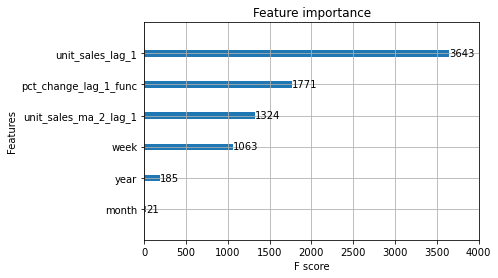

In [23]:
model.fit(X_train, y_train)
plot_importance(model)

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

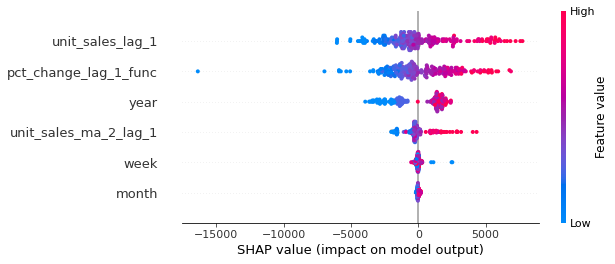

In [25]:
shap.summary_plot(shap_values, X)

## Seasonality Calculation

In [26]:
df_seasonality = df.copy()
df_seasonality['unit_sales_ma_4_lag_1'] = df_seasonality['unit_sales'].rolling(4).mean().shift(1)
df_seasonality.dropna(inplace=True)
df_seasonality

,date,unit_sales,unit_sales_lag_1,unit_sales_ma_2_lag_1,pct_change_lag_1_func,week,month,year,unit_sales_ma_4_lag_1
4,2013-02-04,13234.000,11211.000,11207.5000,0.180448,6,2,2013,13036.50000
5,2013-02-11,14028.000,13234.000,12222.5000,0.059997,7,2,2013,11767.00000
6,2013-02-18,12678.000,14028.000,13631.0000,-0.096236,8,2,2013,12419.25000
7,2013-02-25,12279.000,12678.000,13353.0000,-0.031472,9,2,2013,12787.75000
8,2013-03-04,13965.000,12279.000,12478.5000,0.137308,10,3,2013,13054.75000
...,...,...,...,...,...,...,...,...,...
236,2017-07-17,30704.038,32572.196,34593.5595,-0.057354,29,7,2017,34177.35050
237,2017-07-24,34821.180,30704.038,31638.1170,0.134091,30,7,2017,34169.38925
238,2017-07-31,37407.993,34821.180,32762.6090,0.074288,31,7,2017,33678.08425
239,2017-08-07,34445.133,37407.993,36114.5865,-0.079204,32,8,2017,33876.35175


<AxesSubplot:title={'center':'Seasonal variation from 4-week moving average'}, xlabel='date'>

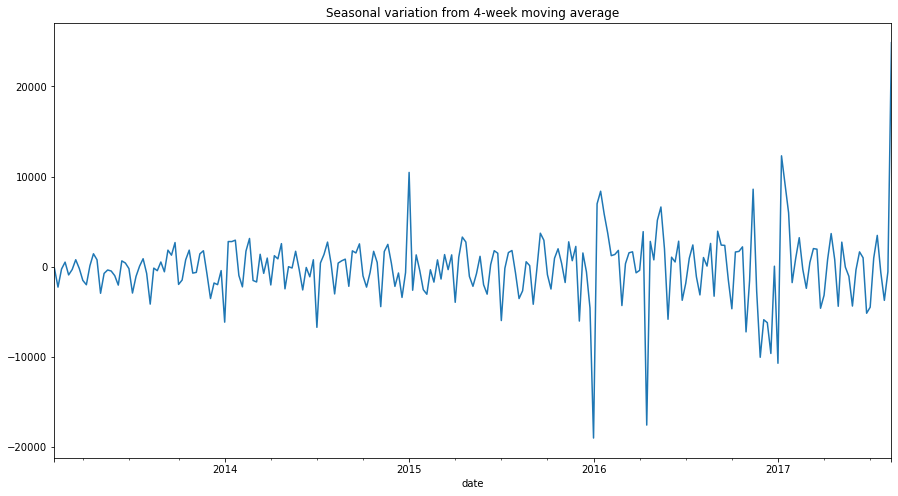

In [27]:
# Calculate seasonality
df_seasonality['sv'] = df_seasonality['unit_sales_ma_4_lag_1'] - df_seasonality['unit_sales']

# Plot it
df_seasonality.set_index('date')['sv'].plot(figsize=(15,8), title='Seasonal variation from 4-week moving average')